In [1]:
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, Layer
from tensorflow.keras import Model, Sequential
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm
import os


In [2]:
DATA_FILE = "x.npy"
batch_size = 32
codings_size = 384

In [3]:
x = np.load(DATA_FILE)[:5000]
img_shape = x.shape[1:]

In [4]:
# The code for this layer came from the HOML book by Geron
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

keras.utils.get_custom_objects().update({"Sampling": Sampling})

# This was block heavily inspired by the HOML book
def add_variational_block(z):
    z = Flatten()(z)
    codings_mean = Dense(codings_size)(z)
    codings_log_var = Dense(codings_size)(z)
    codings = Sampling()((codings_mean, codings_log_var))
    z = Reshape((1, 1, codings_size))(codings)
    return z, codings_mean, codings_log_var

# Also from the HOML book
def latent_loss(codings_mean, codings_log_var):
    latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
    return K.mean(latent_loss) / (img_shape[0]*img_shape[1])

In [5]:
input_tensor = Input(shape=img_shape)

c1 = Conv2D(6, 5, strides=2, padding="same", activation='selu')
c2 = Conv2D(12, 3, strides=2, padding="same", activation='selu')
c3 = Conv2D(24, 3, strides=2, padding="same", activation='selu')
c4 = Conv2D(48, 3, strides=2, padding="same", activation='selu')
c5 = Conv2D(96, 3, strides=2, padding="same", activation='selu')
c6 = Conv2D(192, 3, strides=2, padding="same", activation='selu')
c7 = Conv2D(codings_size, 3, strides=2, padding="same", activation='selu')

ct1 = Conv2DTranspose(192, 3, strides=2, padding="same", activation='selu')
ct2 = Conv2DTranspose(96, 3, strides=2, padding="same", activation='selu')
ct3 = Conv2DTranspose(48, 3, strides=2, padding="same", activation='selu')
ct4 = Conv2DTranspose(24, 3, strides=2, padding="same", activation='selu')
ct5 = Conv2DTranspose(12, 3, strides=2, padding="same", activation='selu')
ct6 = Conv2DTranspose(6, 3, strides=2, padding="same", activation='selu')
ct7 = Conv2DTranspose(3, 3, strides=2, padding="same", activation='sigmoid')

z = input_tensor
for layer in [c1, c2, c3, c4, c5, c6, c7]:
    z = layer(z)

coding_layer, means, log_vars = add_variational_block(z)

decoder_input = Input(shape=(1, 1, codings_size))
z = decoder_input
for layer in [ct1, ct2, ct3, ct4, ct5, ct6, ct7]:
    z = layer(z)

output_tensor = z

decoder  = Model(inputs=[decoder_input], outputs=[output_tensor])

output_tensor = decoder(coding_layer)

autoencoder = Model(inputs=[input_tensor], outputs=[output_tensor])
autoencoder.summary()
# decoder = Model(inputs=[decoder_input], outputs=[output_tensor])
# autoencoder.build(input_shape=img_shape)
autoencoder.add_loss(latent_loss(means, log_vars))
autoencoder.compile(loss="MSE", optimizer="adam")
# autoencoder.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 6)    456         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 12)   660         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 24)   2616        conv2d_1[0][0]                   
_______________________________________________________________________________________

In [6]:
autoencoder.fit(x, x, epochs=20)

Epoch 1/20
157/157 [==============================] - 4s 24ms/step - loss: 0.0419
Epoch 2/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0245
Epoch 3/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0224
Epoch 4/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0215
Epoch 5/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0206
Epoch 6/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0197
Epoch 7/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0189
Epoch 8/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0179
Epoch 9/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0172
Epoch 10/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0165
Epoch 11/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0161
Epoch 12/20
157/157 [==============================] - 4s 23ms/step - loss: 0.0158
Epoch 13/20
1

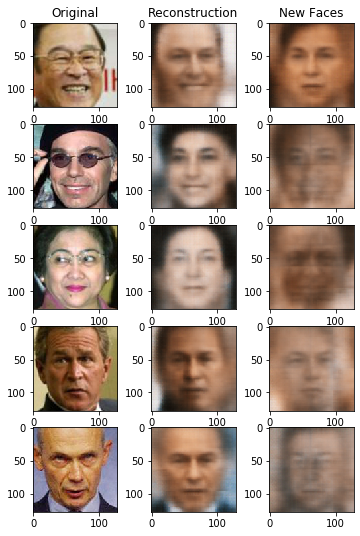

In [7]:
imgs = np.random.randint(0, x.shape[0], 5)
display_images = x[imgs, :, :, :]

reconstructions = autoencoder.predict(display_images)
# basic_reconstructions = stacked_model.predict(display_images)
latent_vecs = np.random.randn(5, 1, 1, codings_size)
new_faces = decoder.predict(latent_vecs)

fig, axs = plt.subplots(5, 3)

titles = ["Original", "Reconstruction", "New Faces"]

for r, row in enumerate(axs):
    imgs = [display_images[r], reconstructions[r], new_faces[r]]
    for c, ax in enumerate(row):
        img = imgs[c].astype(float)
        ax.imshow(img)
        if r == 0:
            ax.set_title(titles[c])

fig.set_size_inches(6, 9)
# fig.savefig("faces.png")
fig.show()

In [8]:
vec = np.random.randn(1, 1, 1, codings_size) * 0.1
vel = -vec * 0.1
img = decoder.predict(vec)[0]
while True:
    vel += np.random.randn(1, 1, 1, codings_size) * 0
    vec += vel
    img = decoder.predict(vec)[0]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imshow("Face", img)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [10]:
autoencoder.save("../models/V_S_7_384.h5")